In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
train_directory = "./data/train"
test_directory = "./data/test"
CLASS_NAMES = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',   
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=99,
)

Found 28709 files belonging to 7 classes.


In [5]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=32,
    image_size=(48, 48),
    shuffle=True,
    seed=99,
)

Found 7178 files belonging to 7 classes.


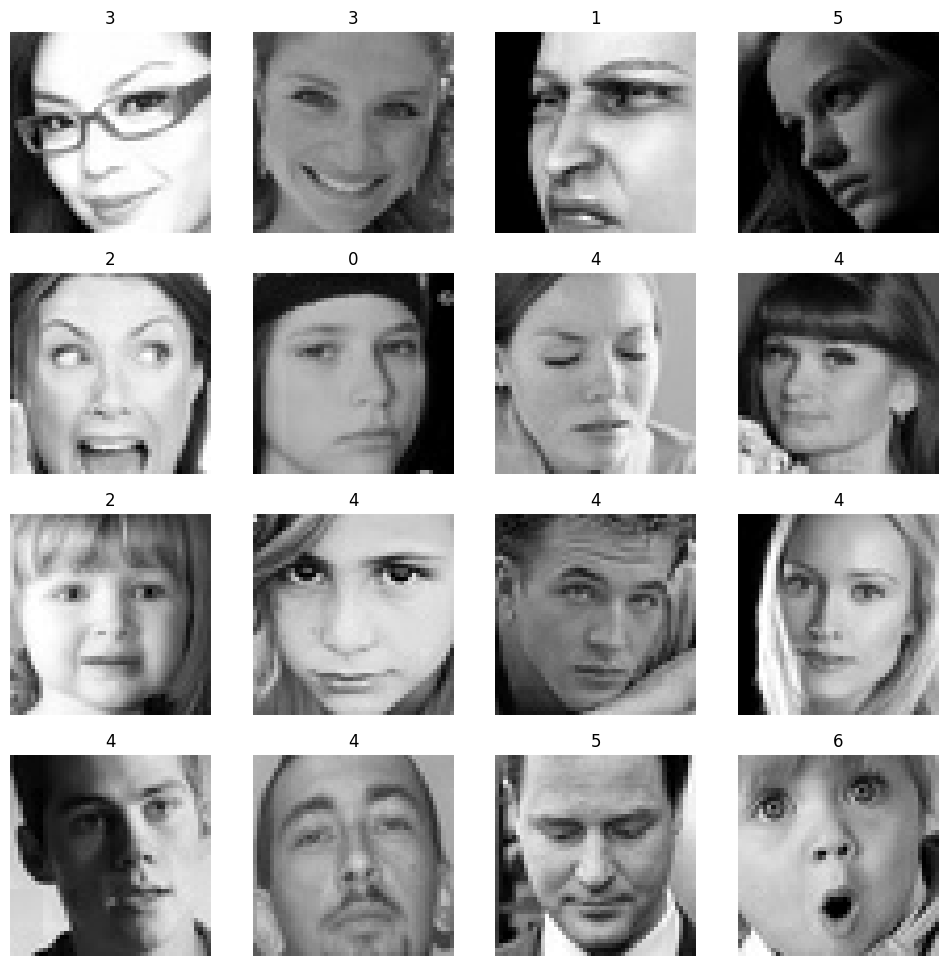

In [6]:
plt.figure(figsize=(12, 12))
for imgs, labels in train_dataset.take(2):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(imgs[i]/255)
        plt.title(np.argmax(labels[i], axis=0))
        plt.axis('off')
        

In [7]:
train_dataset = (train_dataset.prefetch(tf.data.AUTOTUNE))
test_dataset = (test_dataset.prefetch(tf.data.AUTOTUNE))

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [38]:
model = models.Sequential([
    layers.InputLayer(input_shape=(48, 48, 3)),
    layers.Rescaling(1./255, name="rescaling"),
    layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu',
                  kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 100)            │       640,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 7)              │            77 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 661,403 (2.52 MB)

 Trainable params: 660,991 (2.52 MB)

 Non-trainable params: 412 (1.61 KB)

In [41]:
history = model.fit(
    train_dataset, 
    validation_data=test_dataset,
    epochs=25)

Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 46ms/step - accuracy: 0.2842 - loss: 2.1846 - val_accuracy: 0.3831 - val_loss: 1.8385
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4232 - loss: 1.5993 - val_accuracy: 0.4033 - val_loss: 1.6259
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4482 - loss: 1.5089 - val_accuracy: 0.4720 - val_loss: 1.4398
Epoch 4/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4749 - loss: 1.4288 - val_accuracy: 0.4671 - val_loss: 1.4649
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.4944 - loss: 1.3933 - val_accuracy: 0.4326 - val_loss: 1.5769
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5018 - loss: 1.3910 - val_accuracy: 0.4681 - val_loss: 1.4552
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.5056 - loss: 1.3794 - val_accuracy: 0.4482 - val_loss: 1.5356
Epoch 8/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5116 - loss: 1.3450 - 

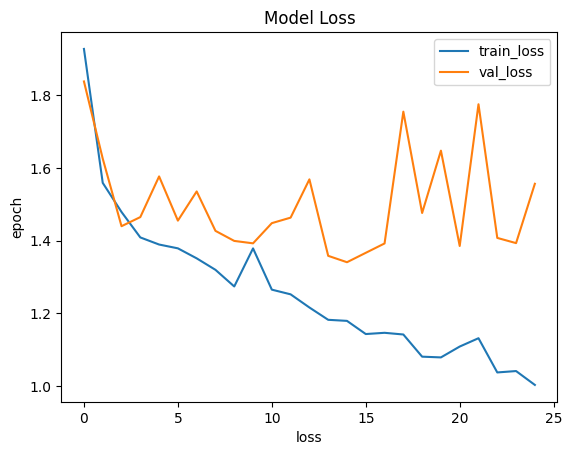

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [43]:
pickle.dump(model, open('model6515.pkl', 'wb'))